<a href="https://colab.research.google.com/github/pugglebert/gdelt-project/blob/main/gdelt_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup from sample GDELT project

In [ ]:
#library and code setup
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

!pip install gdelt

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [ ]:
#start spark local server
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYTHONHASHSEED"]=str(0)

import pyspark
from pyspark import SparkConf, SparkContext

#connects our python driver to a local Spark JVM running on the Google Colab server virtual machine
try:
  conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g")
  sc = SparkContext(conf = conf)
except ValueError:
  #it's ok if the server is already started
  pass

Constants which control the scenario being tested. Change START_DATE and END_DATE to test different time periods. Set FILTER_BY_MIN_ENTRIES to True to only include results from countries where there are more results in the the data than the number given by MIN_ENTRIES

In [ ]:
# Set up constants
START_DATE = '2021 May 01'
END_DATE = '2021 May 31'
MIN_ENTRIES = 20
FILTER_BY_MIN_ENTRIES = True

Download the files with additional data needed for running the algorithm

In [ ]:
!wget -q http://data.gdeltproject.org/documentation/GCAM-MASTER-CODEBOOK.TXT
!wget -q https://raw.githubusercontent.com/datasets/fips-10-4/master/data/data.csv

Fetching GDELT GKG data for given start and end dates


In [ ]:
from concurrent.futures import ProcessPoolExecutor
from datetime import date, timedelta
import pandas as pd
import gdelt
import os

# set up gdeltpyr for version 2
gd = gdelt.gdelt(version=2)

# multiprocess the query
e = ProcessPoolExecutor()


# generic functions to pull and write data to disk based on date
def get_filename(x):
  date = x.strftime('%Y%m%d')
  return "{}_gdeltdata.csv".format(date)

def intofile(filename):
    try:
        if not os.path.exists(filename):
          date = filename.split("_")[0]
          d = gd.Search(date, table='gkg',coverage=True)
          d.to_csv(filename,encoding='utf-8',index=False)
    except:
        print("Error occurred")

# pull the data from gdelt into multi files; this may take a long time
filenames = [get_filename(x) for x in pd.date_range(START_DATE, END_DATE)]

results = list(e.map(intofile, filenames))

/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210503020000
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210502033000
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210503041500
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210503051500
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210502060000
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210503054500
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarn

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

data = sqlContext.read.option("header", "true").csv(filenames)

rdd = data.rdd
print("Problem size:", rdd.count())

Problem size: 3155097


Start timing

In [ ]:
start_time = time.time()

Read the GCAMs from the GCAM-MASTER-CODEBOOK.TXT into a dictionary and broadcast it

In [ ]:
def broadcast_gcams():
  """Broadcast a map with the identifiers of English gcams as the key and a incremented index as the value.
  GCAM master codebook file must be uploaded to colab files."""
  gcam_codebook = sc.textFile('GCAM-MASTER-CODEBOOK.TXT')
  gcam_lines = gcam_codebook.map(lambda line : line.split('\t'))
  english_gcams = gcam_lines.filter(lambda row : row[4] == 'eng').map(lambda row : row[0]).zipWithIndex()
  broadcast_gcams = sc.broadcast(english_gcams.collectAsMap())
  return broadcast_gcams

gcam_dict = broadcast_gcams()

Filter the GKG entries to just the relevant columns, and to those which are in English, only mention one country as their location and relate to the theme of climate change

In [ ]:
def get_countries_from_locations(locations):
  """Takes a string from the 'Locations' column of the GKG data an returns a list
  of the 2 digit FIPS 10-4 country codes from the column."""
  if locations == None:
    return []
  location_list = locations.split(';')
  country_list = [location for location in location_list if location[0] == '1']
  country_codes = [country.split('#')[2] for country in country_list]
  return country_codes

# From the GKG data, get just the location, themems, GCAMs and translation info
relevant_columns = rdd.map(lambda row: ((row['Locations'], row['V2Themes'], row['GCAM'], row['TranslationInfo'])))

# Filter to entries relating to climate change
climate_entries = relevant_columns.filter(lambda row : row[1] != None and 'ENV_CLIMATECHANGE' in row[1])

# Filter to entries which have not been translated
english_entries = climate_entries.filter(lambda row : row[3] == None)

# From the english entires, take just the countries from the location column and the GCAM string
country_and_gcam_columns = english_entries.map(lambda row : (get_countries_from_locations(row[0]), row[2]))

# Filter to entries which mention only one country in the location column and replace the list of countries with the two letter country code
single_country_entries = country_and_gcam_columns.filter(lambda row : len(row[0]) == 1).map(lambda row : (row[0][0], row[1]))

If required, filter the results to only include countries for which there is more than a set minimum number of entries in the results

In [ ]:
if FILTER_BY_MIN_ENTRIES:

  # Find the country codes for countries where the number of entries is above the minimum
  country_codes_for_count = single_country_entries.map(lambda row : (row[0], 1))
  country_code_counts = country_codes_for_count.reduceByKey(lambda x, y : x + y)
  country_codes_above_min = country_code_counts.filter(lambda x : x[1] >= MIN_ENTRIES)

  # Filter the rdd to only include countries where the number of entries is above the minimum
  filter_codes = sc.broadcast(country_codes_above_min.collectAsMap())
  single_country_entries = single_country_entries.filter(lambda x : x[0] in filter_codes.value)

From each line in the results, construct an array where the each index corresponds to a GCAM and each value corresponds to the entry's value for that GCAM. Then aggregate all the arrays from one country into a single array.

In [ ]:
import numpy as np

def get_gcam_array(gcam_line, gcam_dict):
  """Takes a line from the GCAM column of a GKG entry and a dictionary mapping
  each GCAM code to an index. Returns an array where the index given by the dictionary
  for each GCAM gives the position in the array and the value in the array is the
  count for that GCAM."""
  gcam_array = np.zeros(len(gcam_dict.value))
  line_list = gcam_line.split(",")
  for entry in line_list:
    id, count = entry.split(":")
    if id in gcam_dict.value:
      gcam_array[gcam_dict.value[id]] = float(count)
  return gcam_array

# Create an array with the value for each gcam at the index given by gcam_dict
gcam_arrays = single_country_entries.map(lambda row : (row[0], get_gcam_array(row[1], gcam_dict)))

# Reduce the arrays for each country into a single array
country_gcam_arrays = gcam_arrays.reduceByKey(lambda x, y: x + y)

# Get the gcam array for New Zealand so that cosine similarity can be calculated
# between this and every other country
nz_gcam_array = country_gcam_arrays.filter(lambda x : x[0] == 'NZ').take(1)[0][1]

Calculate the cosine similarity between the GCAM array for New Zealand and every other country in the data

In [ ]:
import math

def dot_prod(vecA, vecB):
  """ Calculates the dot product of two list of integers representing vectors"""
  if len(vecA) == len(vecB):
    dot_product = 0
    for i in range(len(vecA)):
      dot_product += vecA[i] * vecB[i]
    return dot_product
  else:
    raise ValueError

def l2_norm(vector):
  """ Calculates the L2 norm of a list of integers representing a vector"""
  sum_of_squares = 0
  for n in vector:
    sum_of_squares += math.pow(n, 2)
  return math.sqrt(sum_of_squares)

def cosine_similarity(vecA, vecB):
  """ Calculates the cosine similarity of two lists of integers representing vectors"""
  dot_product = dot_prod(vecA, vecB)
  normA = l2_norm(vecA)
  normB = l2_norm(vecB)
  return dot_product / (normA * normB)

cosine_similarities = country_gcam_arrays.map(lambda x : (x[0], cosine_similarity(nz_gcam_array, x[1])))

Read data.csv file with FIPS 10-4 codes to create an RDD which maps country codes to country names, and join this with the cosine similarities RDD to get cosine simiarity by country name. Then print the final result with cosine similarity ordered from highest to lowest. Cosine similarity between New Zealand and itself has been left in the results as a sanity check.

In [ ]:
# Load file with all FIPS 10-4 codes and use it to create RDD mapping FIPS code to country name
fips_lines = sc.textFile('data.csv')
fips_columns = fips_lines.map(lambda row : row.split(','))
fips_countries = fips_columns.filter(lambda row : row[1] == 'country')
fips_codes = fips_countries.map(lambda row : (row[0][0:2], row[2]))

# Join with cosine similarity data to map find names of countries with highest similarity
code_to_name_and_similarity = fips_codes.join(cosine_similarities)
name_to_similarity = code_to_name_and_similarity.map(lambda x : (x[1][0], x[1][1]))
collected_result = name_to_similarity.sortBy(lambda x : -1 * x[1]).collect()
print(collected_result)

[('NEW ZEALAND', 1.0), ('CANADA', 0.9982031170551503), ('IRELAND', 0.9979695453826448), ('AUSTRALIA', 0.9979342605097392), ('UNITED STATES', 0.9975639013764225), ('MALAYSIA', 0.9975036161732419), ('UNITED KINGDOM', 0.9973307408099504), ('ZIMBABWE', 0.9972649880922649), ('NORWAY', 0.9969452608911722), ('GERMANY', 0.9968471105773473), ('SOUTH AFRICA', 0.9967896159155151), ('RUSSIA', 0.9966862456867727), ('NIGERIA', 0.9965541010930448), ('INDIA', 0.9965169970377306), ('BRAZIL', 0.9964696969222854), ('PHILIPPINES', 0.9964459439578118), ('SWITZERLAND', 0.9963668071470784), ('KENYA', 0.9962286289786203), ('SPAIN', 0.996211862776057), ('BANGLADESH', 0.9962092070710793), ('JERSEY', 0.9961429086816207), ('ISRAEL', 0.9961266924369175), ('JAPAN', 0.9961137722347074), ('SAUDI ARABIA', 0.9960940606489161), ('TAIWAN', 0.9960261349659915), ('CHINA', 0.9960079753120334), ('UGANDA', 0.9959132433807296), ('SINGAPORE', 0.9956810588667018), ('FINLAND', 0.9955300615527226), ('NETHERLANDS', 0.99545280611930

End timing

In [ ]:
end_time = time.time()
print("Execution time:", end_time - start_time)

Execution time: 1537.898682832718


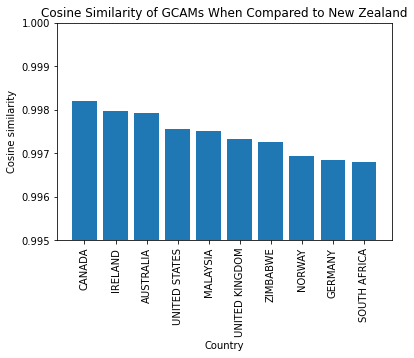

In [ ]:
import matplotlib.pyplot as plt

country_names = [tup[0] for tup in collected_result[1:11]]
similarities = [tup[1] for tup in collected_result[1:11]]
plt.bar(country_names, similarities)

plt.title('Cosine Similarity of GCAMs When Compared to New Zealand')

plt.xlabel('Country')
plt.xticks(rotation=90)

plt.ylabel('Cosine similarity')
plt.ylim([0.995, 1.0])

plt.show()